This notebook contains examples on how to use the Python module `spectra`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


import spectra

Start by choosing an example molecule. This repository contains data on the dipole moment of
$\mathrm{H_2}$, 
$\mathrm{H_2O}$, 
$\mathrm{NH_3}$, 
$\mathrm{CH_4}$, and 
$\mathrm{C_6H_6}$.

The data includes long dipole trajectories, in order to obtain high resolution referance spectra. All data is given in atomic units.

In [2]:
molecule = "H2O" # change system here

data = np.load(f"data/{molecule}.npz", allow_pickle=True)
print(f"{molecule} with {data['basis']} basis, using RT-TD{data['method']}.")


F = float(data["field_strength"])/(2*np.pi)
dipole_moment = data["dipole_moment"]
time_points = data["time_points"]
dt = float(data["dt"])
gamma = np.pi/time_points[-1]
IP = 1 - data["HOMO"]
print(f"Estimate of ionization potential: {IP:.4g} a.u., time step {dt = :.1g}.")

H2O with aug-ucc-pVDZ basis, using RT-TDDFT.
Estimate of ionization potential: 1.333 a.u., time step dt = 0.01.


# The discrete Fourier transform

The function `discrete_spectrum` calculates the absorption spectrum based on discrete values of the dipole moment:

In [3]:
spectra.discrete_spectrum?

It relies on a fast Fourier transfrom implemented in `fourier_transform` with damping parameter `gamma`:

In [4]:
spectra.fourier_transform?

Below is an example showing the referance spectrum and a spectrum using a shorter dipole trajectory.

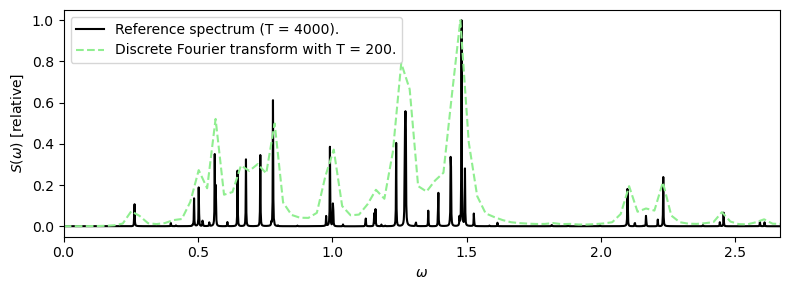

In [5]:
T = 200   # change trajectory length

damping = np.pi/T
omega_max = IP*2

N = int(T/dt) + 1
omega_, FFT = spectra.discrete_spectrum(dipole_moment[:, :N], dt, F, damping, normalize=True)
omega, reference_spectrum = spectra.discrete_spectrum(dipole_moment, dt, F, gamma, normalize=False)
S_max = reference_spectrum.max()
T_ref = int(time_points[-1])

plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$\omega$", ylabel="$S(\omega)$ [relative]", xlim=(0, omega_max))
plt.plot(omega, reference_spectrum/S_max, color="black", label=f"Reference spectrum (T = {T_ref}).")
plt.plot(omega_, FFT, "--", color="lightgreen", label=f"Discrete Fourier transform with {T = }.")
plt.legend()
plt.tight_layout();

# [The Fourier-Padé approximant](https://doi.org/10.1021/acs.jctc.6b00511)

The Fourier-Padé approximant is used to interpolate the discrete Fourier transfrom, originally introduced to real-time calculations of absorption spectra
by [Bruner et al.](https://doi.org/10.1021/acs.jctc.6b00511). 
The module includes the class

In [6]:
spectra.FourierPade?

creating the Fourier Padé based on discrete values of the dipole moment. In order to obtain the full spectrum, one should create three separate Padé approximants - one for each spatial direction.

The `FourierPade` objects can then be used as arguments in

In [7]:
spectra.pade_spectrum?

creating the absorption spectrum with arbitrary resolution.

Below is an example of how to create an absorption spectrum using the Fourier-Padé approximant:

Padé can be evaluated at any point: (-0.000633044426499056+8.357121455855595e-09j)


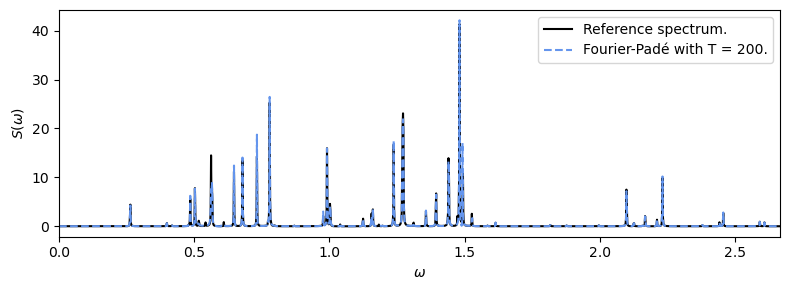

In [8]:
T = 200 # change trajectory length

N = int(T/dt) + 1
MM_x = spectra.FourierPade(dipole_moment[0, :N], dt)
MM_y = spectra.FourierPade(dipole_moment[1, :N], dt)
MM_z = spectra.FourierPade(dipole_moment[2, :N], dt)

print("Padé can be evaluated at any point:", MM_x(IP, gamma=0))

N_pade = int(omega_max/omega[1]) + 1 
S_pade = spectra.pade_spectrum(MM_x, MM_y, MM_z, omega[:N_pade], F, gamma, normalize=False)

plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$\omega$", ylabel="$S(\omega)$", xlim=(0, omega_max))
plt.plot(omega, reference_spectrum, color="black", label=f"Reference spectrum.")
plt.plot(omega[:N_pade], S_pade, "--", color="cornflowerblue", label=f"Fourier-Padé with {T = }.")
plt.legend()
plt.tight_layout();

# Filtering the dipole moment

The larger frequencies can be filtered out of the discrete signal by using a *low-pass* filter:

In [9]:
spectra.low_pass?

The cut-off frequency for the filtering of the dipole moment should be somewhat generous. The cut-off is not sharp and will lower the intensities of the peaks to the immediate left of the cut-off frequency. 

The filtered spectrum is shown below.

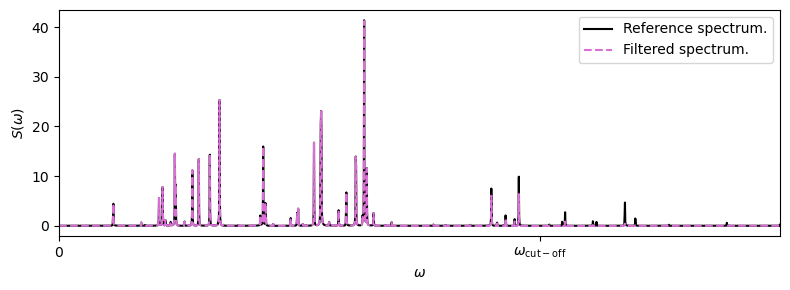

In [10]:
# decide the cut-off frequency, 
# here we use the rough estimate of the ionization potential with a buffer
cutoff_frequency = IP + 1

filtered = [spectra.low_pass(dipole, dt, cutoff_frequency) for dipole in dipole_moment]

N = int(T/dt) + 1
omega, filtered_spectrum = spectra.discrete_spectrum(filtered, dt, F, gamma, normalize=False)

plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$\omega$", ylabel="$S(\omega)$", xlim=(0, 1.5*cutoff_frequency))
plt.plot(omega, reference_spectrum, color="black", label=f"Reference spectrum.")
plt.plot(omega, filtered_spectrum, "--", color="orchid", label=f"Filtered spectrum.")
plt.xticks([0, cutoff_frequency], ["0", r"$\omega_\mathrm{cut-off}$"])
plt.legend()
plt.tight_layout();

# Extrapolating the time dependent dipole moment

The class `DipoleMoment` may be used to extrapolate the dipole moment based on a shorter discrete trajectory, based on [Hauge's master thesis](https://www.duo.uio.no/handle/10852/91284).

In [11]:
spectra.DipoleMoment?

The class `BroadbandDipole` should only be used to extrapolate the dipole moment induced by interactions with a Dirac delta impulse, as introduced by [Repisky et al.](https://doi.org/10.1021/ct501078d). All example systems given in this repository have used this type of external field.

In [12]:
spectra.BroadbandDipole?

One instance is needed per spatial direction. When initalizing, provide the cut-off frequency and the error tolerance of the fit. The tolerance is used to determine the convergence of the fit.

In [13]:
E_tol = 5e-3
use_broadband = True

if use_broadband:
    mu_x = spectra.BroadbandDipole(cutoff_frequency, error_tol=E_tol)
    mu_y = spectra.BroadbandDipole(cutoff_frequency, error_tol=E_tol)
    mu_z = spectra.BroadbandDipole(cutoff_frequency, error_tol=E_tol)
else:
    mu_x = spectra.DipoleMoment(cutoff_frequency, error_tol=E_tol)
    mu_y = spectra.DipoleMoment(cutoff_frequency, error_tol=E_tol)
    mu_z = spectra.DipoleMoment(cutoff_frequency, error_tol=E_tol)   

Provide an initial trajectory length `T_min` of the dipole moment, when first trying to attempt to fit the dipole moment. If not successful, try to fit again after *calculating* `dT` further in time. This is repeated until the error of the fit is lower than `error_tol`, or the maximum trajectory length `T_max` is reached.

In [14]:
T_min = 100
T_max = 1000
dT = 100
T_fig = 1000 # only used for plotting

N_min = int(T_min/dt) + 1
dN = int(dT/dt)
N_max = int(T_max/dt) + 1
N_fig = int(T_fig/dt) + 1

Provide the discrete dipole data with the corresponding time points in to the `fit` method:

In [15]:
spectra.DipoleMoment.fit?

The fit of $\mu_x$ is performed below:

Error using T_ver = 100 was 1.87e-01.
Final error using T_ver = 200 was 7.20e-05.


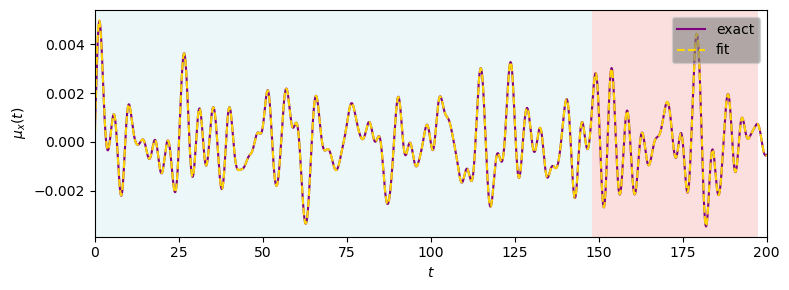

In [16]:
Nx = N_min
while not mu_x.fit(dipole_moment[0, :Nx], time_points[:Nx]) and Nx < N_max:
    print(f"Error using T_ver = {time_points[Nx]:.0f} was {mu_x.error:.2e}.")
    # pretending to calculate dN more points in time
    Nx += dN
print(f"Final error using T_ver = {time_points[Nx]:.0f} was {mu_x.error:.2e}.")

T_fit = mu_x.fit_verification_ratio*(Nx - mu_x._number_of_unstable_points(dt))*dt
T_ver = (Nx - mu_x._number_of_unstable_points(dt))*dt
plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$t$", ylabel="$\mu_x(t)$", xlim=(0, Nx*dt))
plt.axvspan(0, T_fit, facecolor='powderblue', alpha=0.25)
plt.axvspan(T_fit, T_ver, facecolor='lightcoral', alpha=0.25)
plt.plot(time_points[:Nx], filtered[0][:Nx], color="purple", label="exact")
plt.plot(time_points[:Nx], mu_x(time_points[:Nx]), "--", color="gold", label="fit")
plt.legend(loc="upper right", framealpha=0.6, facecolor="gray")
plt.tight_layout()

The **blue background** shows the part used to optimize the linear coefficients. The **red background** shows the part which was used to calculate the error of the fit. The rest (white part) was discarded due to instabilities at the end of the filtered trajectory. The length of the discarded part is determined by the data field `unstable_cycles`, where one cycle is $2\pi/\omega_\mathrm{cut-off}$.

Same procedure when fitting the $y$-direction:

Error using T_ver = 100 was 5.64e-02.
Error using T_ver = 200 was 1.45e-02.
Final error using T_ver = 300 was 6.85e-06.


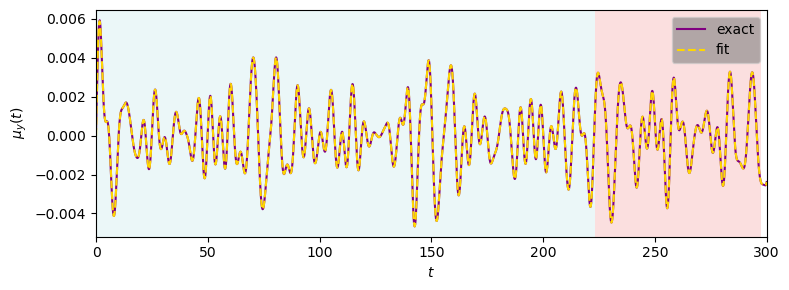

In [17]:
Ny = N_min
while not mu_y.fit(dipole_moment[1, :Ny], time_points[:Ny]) and Ny < N_max:
    print(f"Error using T_ver = {time_points[Ny]:.0f} was {mu_y.error:.2e}.")
    Ny += dN
print(f"Final error using T_ver = {time_points[Ny]:.0f} was {mu_y.error:.2e}.")

T_fit = mu_y.fit_verification_ratio*(Ny - mu_y._number_of_unstable_points(dt))*dt
T_ver = (Ny - mu_y._number_of_unstable_points(dt))*dt
plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$t$", ylabel="$\mu_y(t)$", xlim=(0, Ny*dt))
plt.axvspan(0, T_fit, facecolor='powderblue', alpha=0.25)
plt.axvspan(T_fit, T_ver, facecolor='lightcoral', alpha=0.25)
plt.plot(time_points[:Ny], filtered[1][:Ny], color="purple", label="exact")
plt.plot(time_points[:Ny], mu_y(time_points[:Ny]), "--", color="gold", label="fit")
plt.legend(loc="upper right", framealpha=0.6, facecolor="gray")
plt.tight_layout();

The computational bottleneck is determining the frequencies. The data field `max_points_pade` on the `DipoleMoment` class determines the maximum number of points used to determine the frequencies. If the number of data points exceeds the limit, their number is reduced by increasing the time step by a integer factor. This increase in the time step is only used when determining the frequencies (when creating the Padé approximant). 

Lastly, the fit of $\mu_z$:

Error using T_ver = 100 was 2.72e-01.
Error using T_ver = 200 was 1.32e-02.
Final error using T_ver = 300 was 2.90e-04.


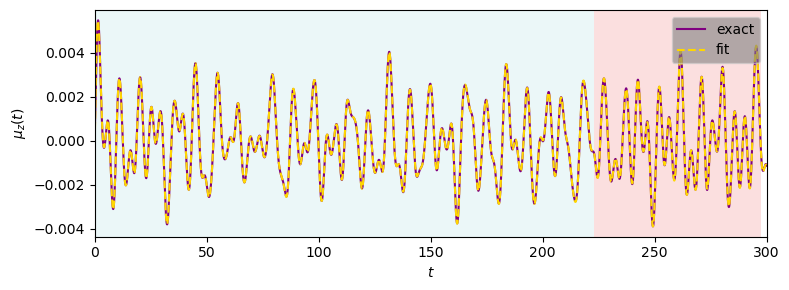

In [18]:
Nz = N_min
while not mu_z.fit(dipole_moment[2, :Nz], time_points[:Nz]) and Nz < N_max:
    print(f"Error using T_ver = {time_points[Nz]:.0f} was {mu_z.error:.2e}.")
    Nz += dN
print(f"Final error using T_ver = {time_points[Nz]:.0f} was {mu_z.error:.2e}.")


T_fit = mu_z.fit_verification_ratio*(Nz - mu_z._number_of_unstable_points(dt))*dt
T_ver = (Nz - mu_z._number_of_unstable_points(dt))*dt
plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$t$", ylabel="$\mu_z(t)$", xlim=(0, Nz*dt))
plt.axvspan(0, T_fit, facecolor='powderblue', alpha=0.25)
plt.axvspan(T_fit, T_ver, facecolor='lightcoral', alpha=0.25)
plt.plot(time_points[:Nz], filtered[2][:Nz], color="purple", label="exact")
plt.plot(time_points[:Nz], mu_z(time_points[:Nz]), "--", color="gold", label="fit")
plt.legend(loc="upper right", framealpha=0.6, facecolor="gray")
plt.tight_layout();

## Extrapolation

The fitted functions may now be evaluated at any point:

In [19]:
mu_x(1e10)

0.0034818070571951566

This is used to extrapolate the dipole moment to achieve better spectral resolution. Here, we extrapolate to the same length as the reference data:

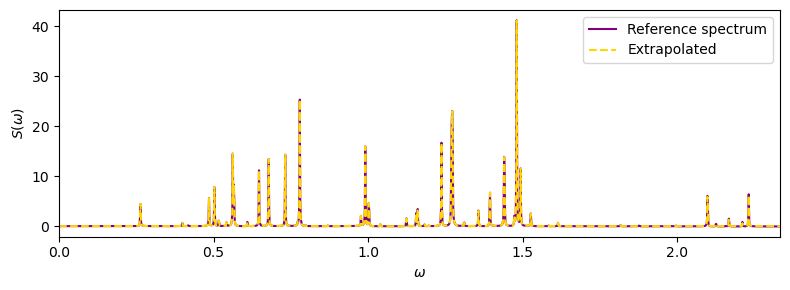

In [20]:
extrapolated = [mu_x(time_points), mu_y(time_points), mu_z(time_points)]

omega, extrapolated_spectrum = spectra.discrete_spectrum(extrapolated, dt, F, gamma, normalize=False)

plt.figure(figsize=(8, 3))
plt.subplot(111, xlabel="$\omega$", ylabel="$S(\omega)$", xlim=(0, cutoff_frequency))
plt.plot(omega, filtered_spectrum, color="purple", label=f"Reference spectrum")
plt.plot(omega, extrapolated_spectrum, "--", color="gold", label=f"Extrapolated")
plt.legend()
plt.tight_layout();

## Analytical spectrum for the fitted function

If using the Dirac delta impulse, the `BroadbandDipole` class has implemented a method for calculating the analytical expression for the Fourier transform:

In [21]:
spectra.BroadbandDipole.transform?

This can be evaluated at any frequency, and may therefore yield arbitrary resolution. 

The absorption spectrum can be obtained by the function:

In [22]:
spectra.absorption_spectrum?

which takes in the Fourier transform of $\mu_x$, $\mu_y$, and $\mu_z$.

An example on how to obtain the spectrum this way is shown below, if the `BroadbandDipole` class was used.

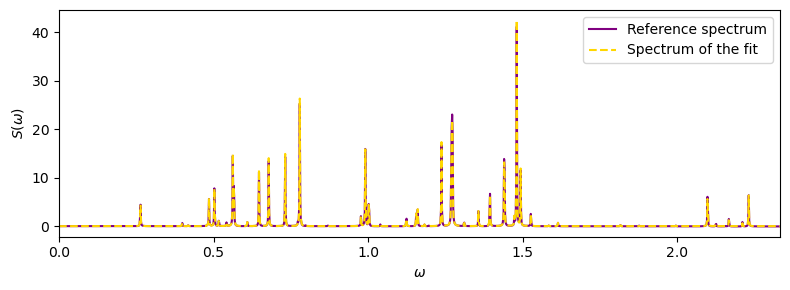

In [23]:
if use_broadband:
    omega_fit = omega[omega < cutoff_frequency]
    FT_x = mu_x.transform(omega_fit, gamma)
    FT_y = mu_y.transform(omega_fit, gamma)
    FT_z = mu_z.transform(omega_fit, gamma)
    S_fit = spectra.absorption_spectrum(FT_x, FT_y, FT_z, omega_fit, F, normalize=False)

    plt.figure(figsize=(8, 3))
    plt.subplot(111, xlabel="$\omega$", ylabel="$S(\omega)$", xlim=(0, cutoff_frequency))
    plt.plot(omega, filtered_spectrum, color="purple", label=f"Reference spectrum")
    plt.plot(omega_fit, S_fit, "--", color="gold", label=f"Spectrum of the fit")
    plt.legend()
    plt.tight_layout();

## Storing the fitted function

The fitting method should be possible to use while running the real-time calculations. The fitted functions may therefore be saved to proceed with the postprocessing later.

### Save the fit

The `DipoleMoment` (and `BroadbandDipole`) class has a method for saving the fit provided a filename:

In [24]:
spectra.DipoleMoment.save?

The fit in each direction may then be stored:

In [25]:
filename = "fit"

mu_x.save(filename + "_x")
mu_y.save(filename + "_y")
mu_z.save(filename + "_z")

This creates a `numpy` zip file with all necessary information. 

### Load the saved function

Given the `numpy` zip file is present, the fit may be loaded by:

In [26]:
spectra.DipoleMoment.load?

This is shown below.

In [27]:
fit_x = spectra.DipoleMoment.load(filename + "_x")
fit_y = spectra.DipoleMoment.load(filename + "_y")
fit_z = spectra.DipoleMoment.load(filename + "_z")
print(f"Error of the fit was {fit_x.error:.3e} in the x direction.")
print(f"Error of the fit was {fit_y.error:.3e} in the y direction.")
print(f"Error of the fit was {fit_z.error:.3e} in the z direction.")
print(f"Cut-off frequency was {fit_x.cutoff_frequency:.3g}, {fit_y.cutoff_frequency:.3g}, and {fit_z.cutoff_frequency:.3g}.")

Error of the fit was 7.201e-05 in the x direction.
Error of the fit was 6.854e-06 in the y direction.
Error of the fit was 2.896e-04 in the z direction.
Cut-off frequency was 2.33, 2.33, and 2.33.


The object still behaves like a function:

In [28]:
fit_x(42)

-0.0008948707929347743

And may therefore be used to extrapolate (and of course calculate the spectrum).

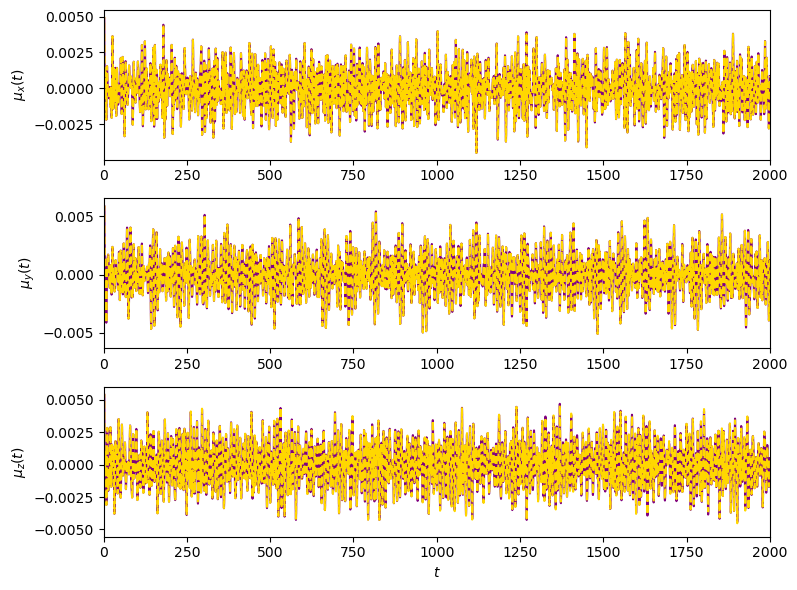

In [29]:
T = 2000

plt.figure(figsize=(8, 6))
plt.subplot(311, xlabel="", ylabel="$\mu_x(t)$", xlim=(0, T))
plt.plot(time_points, filtered[0], color="purple")
plt.plot(time_points, fit_x(time_points), "--", color="gold")
plt.subplot(312, xlabel="", ylabel="$\mu_y(t)$", xlim=(0, T))
plt.plot(time_points, filtered[1], color="purple")
plt.plot(time_points, fit_y(time_points), "--", color="gold")
plt.subplot(313, xlabel="$t$", ylabel="$\mu_z(t)$", xlim=(0, T))
plt.plot(time_points, filtered[2], color="purple")
plt.plot(time_points, fit_z(time_points), "--", color="gold")
plt.tight_layout()

The environment file `environment.yml` contains information on which packages are needed to run this notebook.